# Solar radiation nowcasting using Markov Chain
**Xinyuan Hou**

Supervisor: **Dr. Stelios Kazadzis**

Index

[Objective](#Objective)

[Data](#Data)

[Model & methods](#Model & methods)

[Results](#Results)

## Objective

The objective of this study is to provide infomation about solar radiation availability in the next hour(s) to aid solar power corporations to schedule input distributions. 

## Data

We use radiation data from Copernicus Atmospheric Monitoring Service (CAMS), and compute the Cloud Modification Factor (CMF), defined as the ratio of GHI in all-sky condition to that in clear-sky conditions (GHI_CS):

$$CMF = \frac{GHI}{GHI_{CS}}$$

If CMF approaches 0, the sky is cloudy, while a CMF value of 1 implies it is clear sky without clouds.

We take the time series with an interval of 15 minutes, extending from 01.02.2004 to 31.12.2019.  The data on CAMS are updated until two days prior to the instantaneous query time.

We choose four cities of different cloud conditions in Europe: 

City           | Coordinates
:--------------|:------------------
Athens         | 37.98° N, 23.72° E 
Bucharest      | 44.44° N, 26.08° E 
Berlin         | 52.52° N, 13.37° E
Helsinki       | 60.19° N, 24.93° E 

which are in descending order of long-term average CMF.

## Model & methods

### Markov Chain

Solar radiation possesses Markov property, which indicates that the evolution of the Markov process in the future depends only on the present state and does not depend on past. This property permits to predict solar radiation via a Markov chain (MC) model; in this study we develop and employ a discrete-time MC model.

Firstly, we divide the CMF time series into the period 2004 to 2018 for fitting the transition matrix from historical occurrence (training set), and the rest year 2019 for testing the performance of the MC model (test set). For the implementation of the hybrid approach (see below), the time series of 2019 are further divided into odd days and even days.

#### State classification

We first classify the CMF values into 30 integer states, each state having the same amount of  data points. Consequently, the lower (higher) ranges of CMF values for each state are not equally spaced, but in larger intervals for smaller CMF values (towards 0) and in smaller intervals at the higher CMF values (towards 1). Firstly, we compute the 30-tiles of the training set as the starts of each bin. Then, we classify the state of each CMF value by comparing it with the start of each bin. We compute the mean CMF value within each class and store these 30 values for later prediction in combination with the transition matrix. 

#### Transition matrix

For the second order Markov chain, we initiate a `n²×n` matrix. The columns represent n possible states for the immediate time step (n=30 in this study), whereas the rows list all `n²` transition cases of states from the previous to the current time step., namely `1→1`, `1→2`, ..., `1→30`, `2→1`, ..., and `30→30`. We count the occurrence of each case to fill into the matrix. After converting the integers to frequencies within each row, we obtain the normalized transition matrix, indicating the frequency of next possible class at a given transition from the previous to the current time step. The sum of a certain row vector might be zero, in this case, the frequency of not a number (`NaN`) is replaced by 0.

#### MC Prediction 

We implement two kinds of Markov chain prediction approaches, noted as Variant a and Variant b.

##### Variant a
From the test set, we take two consecutive values as the observation and compute the value at the next step from the pre-calculated transition matrix. Rather than using random uniform sampling, as employed in some previous studies (#ref), we compute the prediction value by weighted mean at the specific row (transition) in the transition matrix.

##### Variant b
To predict the CMF values longer than two time steps ahead of the current time step, we take two consecutive values from the test set as the observation and we predict the value for the next time step following variant a.  For the prediction of one further time step, the previous two observation points consist of the latter one from the record and the newly predicted one, and we apply the prediction following variant a. If the value at one further time step is needed, the new observation would be the two consecutive predictions. We repeat this procedure until reaching the prediction for four time steps ahead.

### Persistence approach

This approach assumes the cloud state does not change from the previous to the current time step, therefore uses the CMF value at the previous time step as the prediction for the current time step. It is essentially a temporal shift of the original time series by a certain interval, in this case, one time step later.

### Hybrid approach

We divide the time series of 2019 into odd days and even days. For the odd days time series, we evaluate the performance of persistence method, MC prediction Variant a and Variant b by mean absolute error (MAE) and root mean square error (RMSE) for all 30 CMF classes. If the error by the certain approach is the smallest among the considered approaches, we adopt this approach for this specific CMF class at the current (known) time step. We apply this method on the even day times series and compute the metrics for the hybrid approach, along with the three previous approaches.

### (Neighbor inference)

Using Berlin as a test bed, we evaluate the viability of inferring CMF values of the central cell from CMF values of its neighbor cells at the previous time step. The neighbor cells are the central cell shifted to these eight directions by 0.1° longitude or/and latitude: to the west, northwest, north, northeast, east, southeast, south and southwest. We first exclude the time steps with CMF values higher than 0.95 (sunny with very few clouds) and compute the Pearson correlation of CMF values at the central cell with those at the neighbor cells to obtain eight correlation coefficients.

### GHI prediction

For the computation of all-sky GHI, we multiply clear-sky GHI provided by CAMS by predicted CMF values following the hybrid approach: 

$$GHI = GHI_{CS} ∙ CMF$$

## Results for Berlin

### CMF distribution

Fig. 1 shows the CMF distributions of training and test sets for Berlin. The test set inherits the classification from the training set, thus does not have equal number of data points in every class.

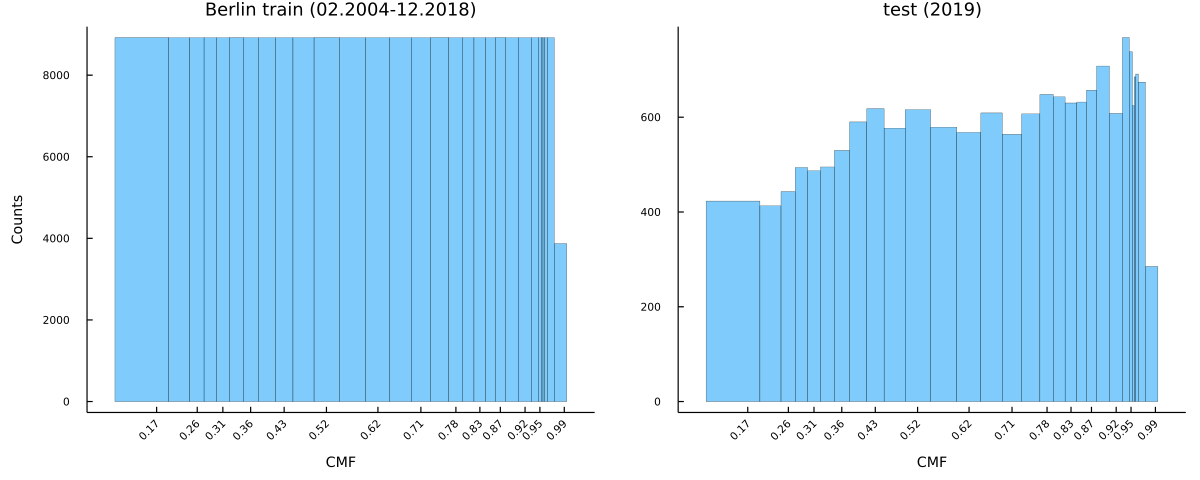

In [23]:
h_ep = plot(h_train, h_test, layout=@layout([a b]), leg=false, grid=false, xlabel="CMF", xrotation=45, 
    lw=0.2, fillalpha=0.5, labelfontsize=8, titlefontsize=10, tickfontsize=6, 
    leftmargin=20px, bottommargin=20px, size=(1000,400))

### Transition matrix

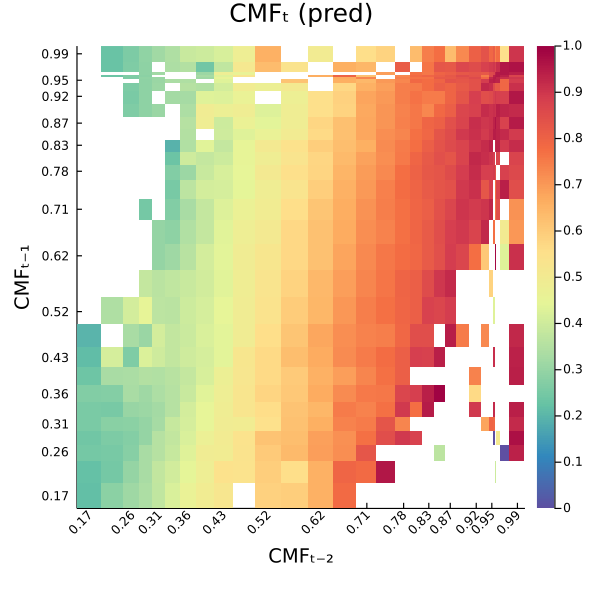

In [38]:
hm_test = heatmap(binMean, binMean, T_test, c=cgrad(:Spectral_10, rev=true), clim=(0,1), grid=false, 
    title="CMFₜ (pred)", size=(500,500), tickfontsize=7,
    xticks=xti, yticks=xti, xrotation=45, 
    xlabel="CMFₜ₋₂", ylabel="CMFₜ₋₁")

### Neighbor inference

Fig. 7 shows the correlation coefficients of the CMF values in Berlin with CMF values from the previous time step (15 minutes before) in the eight neighbor cells. Here, clear-sky states are excluded by filtering out CMF values larger than or equal to 0.95. The highest correlation is with the cell to the west, followed by the cells in the northwest and southwest. Moving towards the east, the correlation decreases and the minimum situates in the southeastern cell. This is as expected, since the general movement of clouds above Berlin is westerly flow. 
Then, we evaluate the performance of using prior CMF values from the western cell in comparison to other prediction approaches. (As can be seen from the Fig. ,) using the earlier CMF value of the western cell does not yield smaller errors than the persistence approach or the MC prediction.

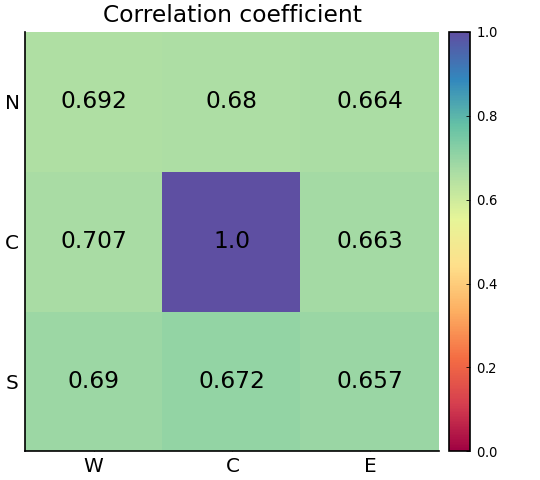

In [43]:
Fig. 7

### CMF prediction
We compare the CMF prediction for the next time step (15 minutes ahead) from each individual approaches and assess their performance referenced by the modelled CMF values from CAMS.

#### Mean & standard deviation

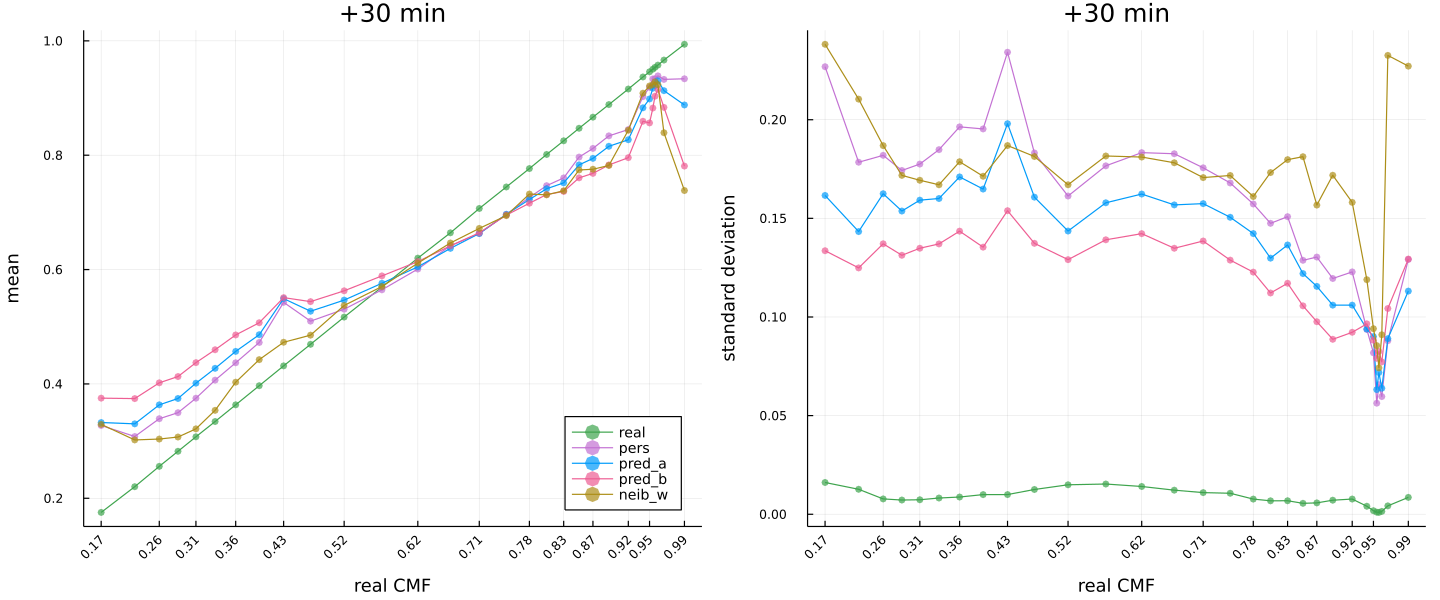

In [69]:
p = plot(mns, sds, leftmargin=20px, bottommargin=20px, size=(1200, 500))

#### Bias

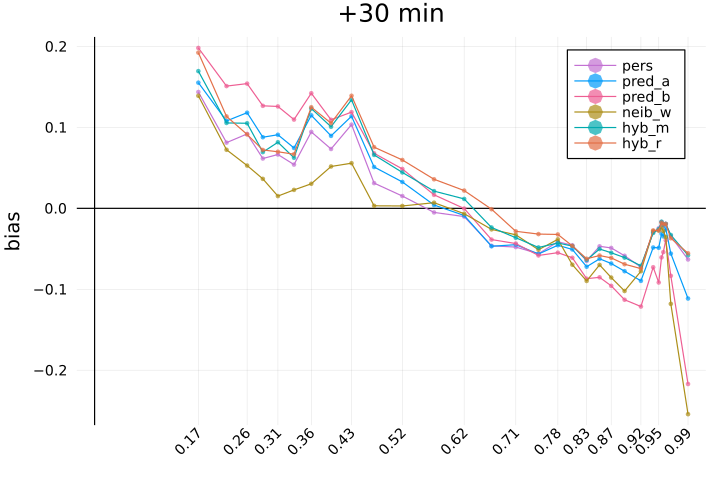

In [103]:
v = plot(binMean, [bias_pers bias_pred bias_pred_n bias_neib bias_hyb_m bias_hyb_r], frame=:zerolines, 
        label=["pers" "pred_a" "pred_b" "neib_w" "hyb_m" "hyb_r"], c=[4 1 7 5 6 2], marker=(2, 0.7, :o, stroke(0)),  
        xticks=xti, xrotation=45, 
        ylabel="bias", title="+30 min")

#### MAE versus RMSE

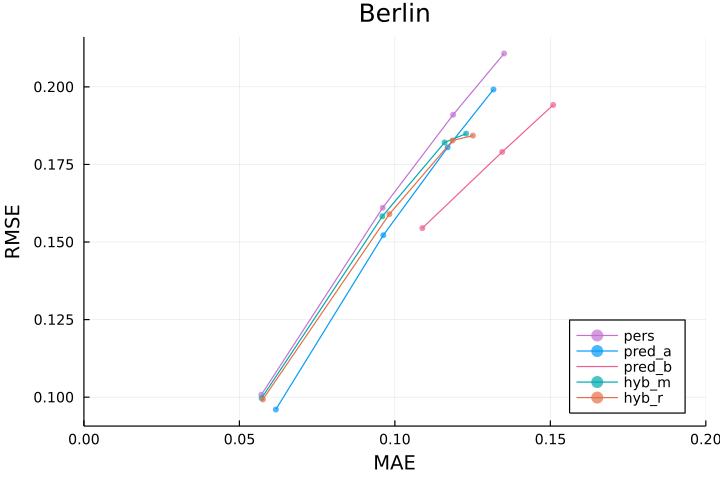

In [21]:
    p = plot(leg=:bottomright, xlim=(0,0.2), aspect_ratio=1, #ylim=(0,0.25), 
        xlabel="MAE", ylabel="RMSE", title="Berlin")
    clrs = [4, 1, 7, 6, 2]
    for i in 1:(len-1)
    plot!(Array(df_err[i,2:5]), Array(df_err[i,6:end]), marker=(3, 0.7, stroke(0)), c=clrs[i], label=lab[i])
    end
p

#### First order difference

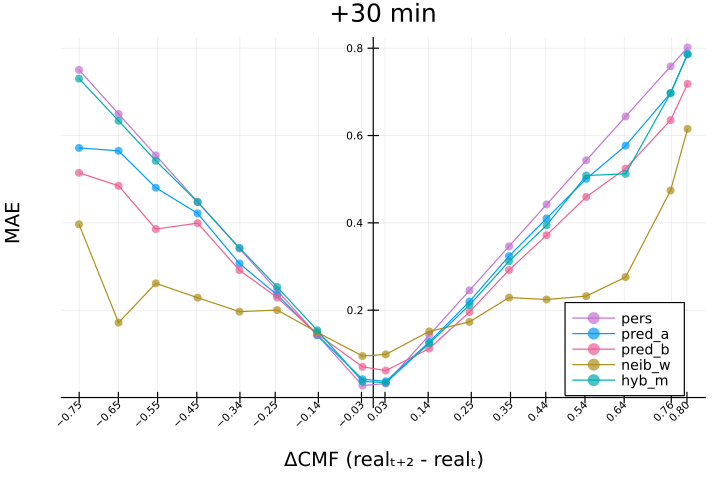

In [31]:
dif2 = viz_dif(df22, 2)

### GHI prediction

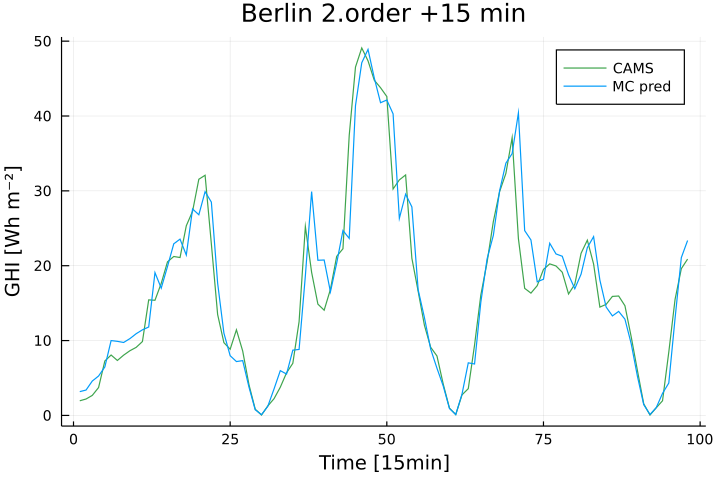

In [55]:
Fig. 

## Results for other cities

### Transition matrix

Fig. 2 shows the transition matrices for the four selected cities. The heatmaps exhibit the CMF values that are most likely to occur at the current time step `t`, given the CMF values two time steps before (`t-2`, horizontal axis) and one time step before (`t-1`, vertical axis). It is visible that these four cities have rather distinct patterns of state transition. For Bucharest and Helsinki, the abrupt transition from very low CMF values to very high ones or the other way around has not occurred in th record, as can be seen from the blank upper left and lower right corners on their heatmaps. For Berlin and Athens, the tranistions follow vertical strips, hinting that the CMF states in both cities mostly depend on the time step `t-2`, and is less affected by the immediate prior time step `t-1`.

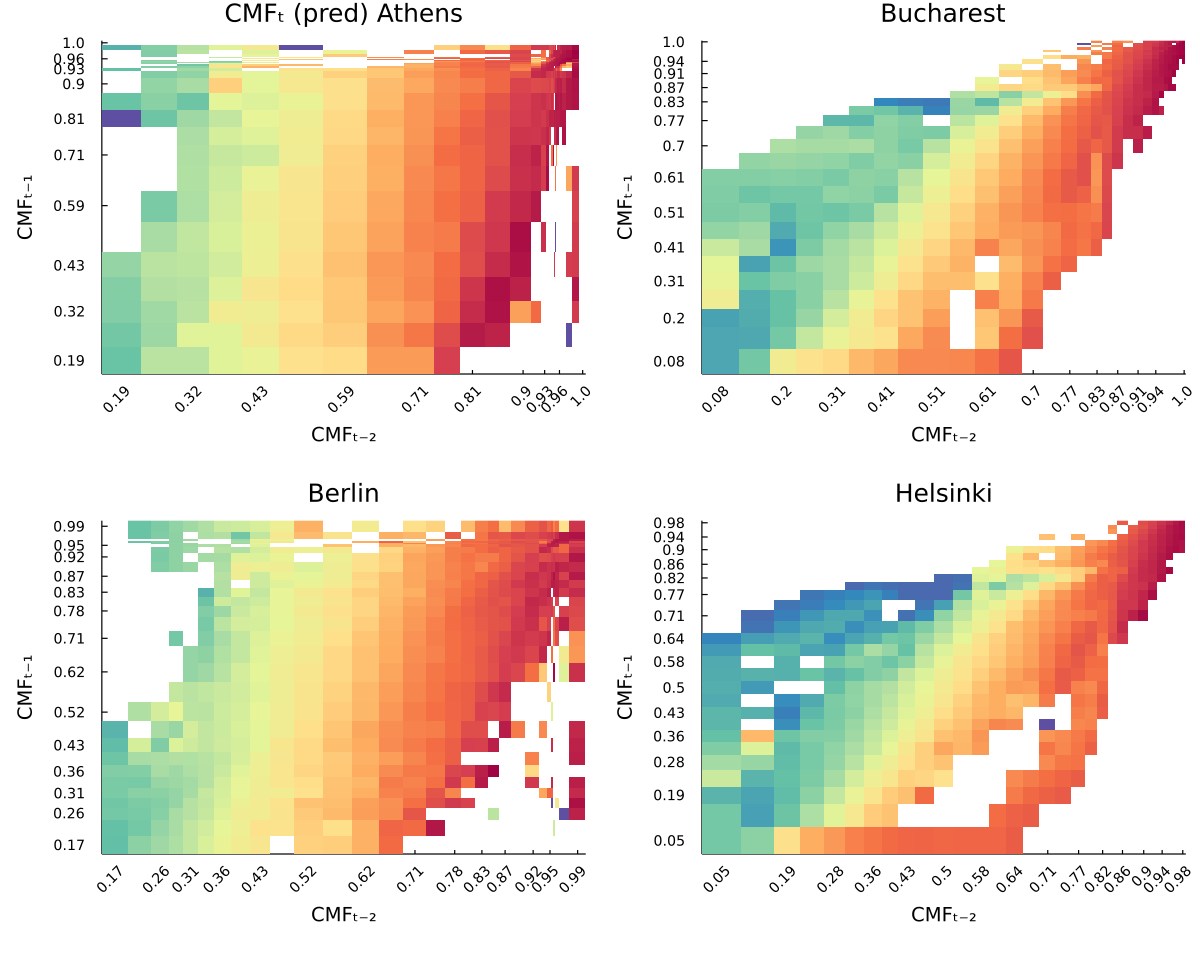

In [12]:
Fig. 2

### CMF prediction

#### Mean & standard deviation

Fig. 3 show the mean and standard deviation of the CMF time series from CAMS, persistence approach, MC prediction variant a, MC prediction variant b, hybrid approach based on MAE and based on RMSE (from left to right). Since the persistence approach is in fact a temporal shift of the time series, it has reasonably the same mean and standard deviation as the CMF time series from CAMS. 

Compared to the persistence approach, the other approaches overestimate the average CMF values by <0.01 in Athens, and underestimate the average in Bucharest and Helsinki. 

In all these four cities, the other approaches perform better than the persistence one regarding the standard deviation. Among them, the MC prediction variant b delivers the minimum standard deivation, indicating the predicted values in the time series deviate from the average to a lesser extent than other approaches. The hybrid approach does not necessarily outperform the MC prediction variant a in terms of standard deviation, which it only achieves both based on MAE or RMSE in Bucharest and Helsinki.

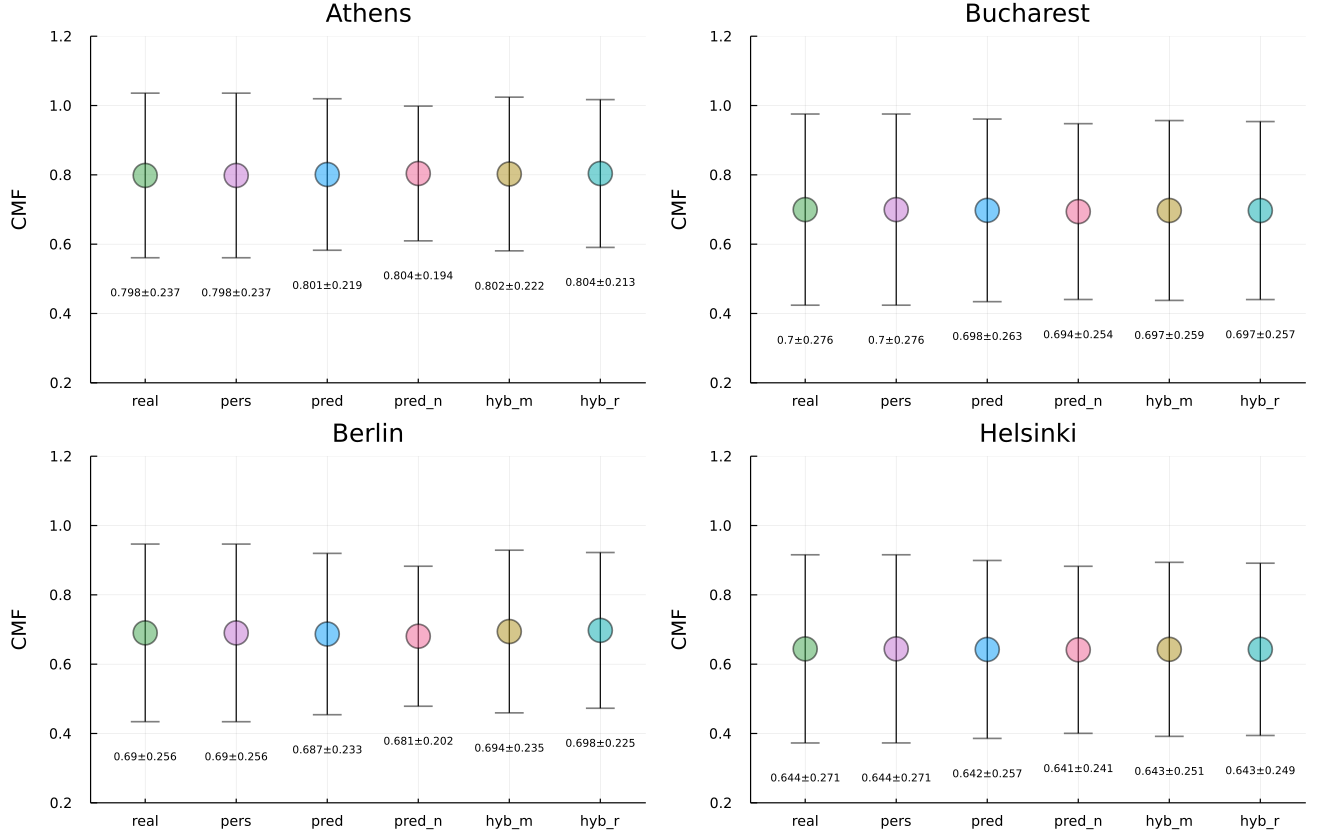

In [51]:
Fig. 3

#### Bias

Fig. 5 show the distribution of CMF bias, namely the difference between predicted CMF and modelled CMF by CAMS, here outliers are not shown. The overall biases are the smallest in Athens (± 0.1), the sunniest city among the four cities. In Berlin, the longer whiskers (5- to 95-percentile range) than in other cities implies a more variable cloud condition thereby harder to predict accurately.

Noticeable is that in all the cities, the CMF bias of the MC prediction variant b has the largest inter-quartile range as well as 5- to 95-percentile range. In Berin, for example, the 5- and 95-percentiles exceed ± 0.3.

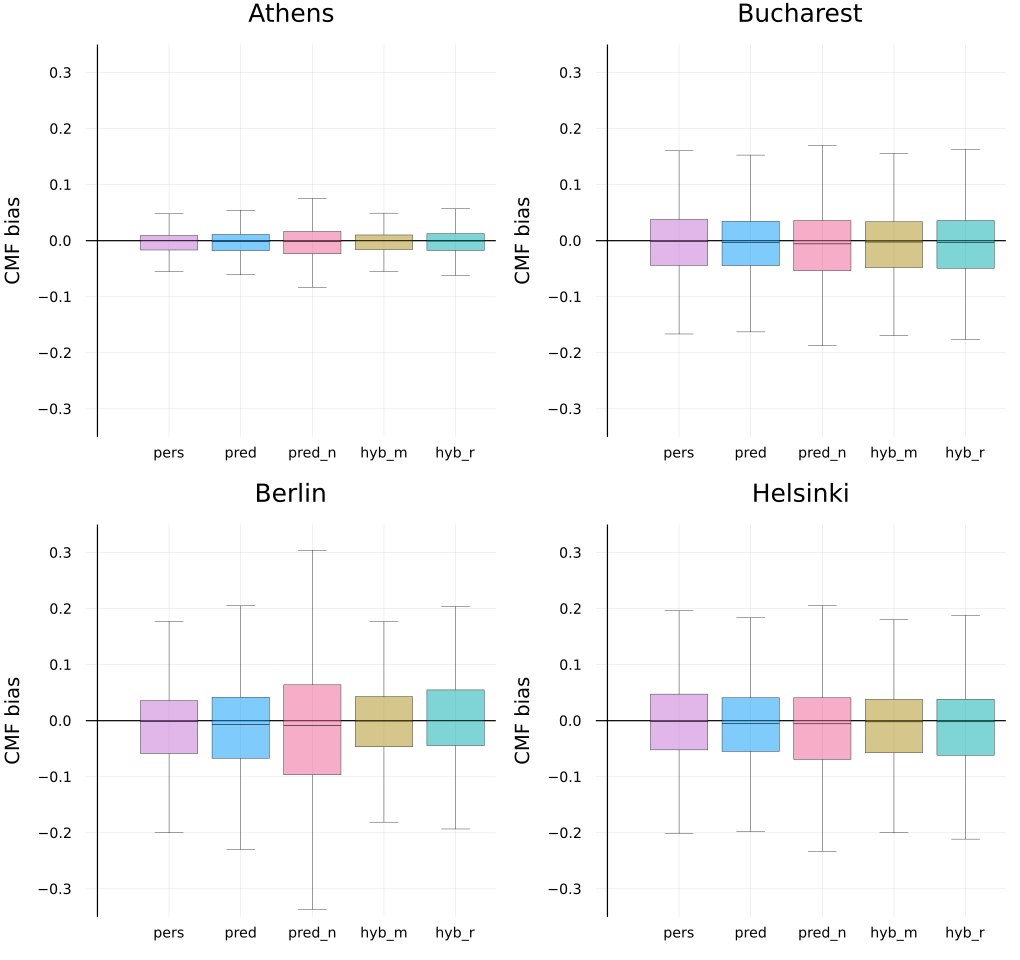

In [62]:
Fig. 5

#### MAE versus RMSE

Fig. 6 show both errors for each approach in four cities. MAE is shown on the horizontal axis and RMSE on the vertical one. Every point of the same color denote the lead time of prediction, namely 15, 30, 45 and 60 minutes from the lower left  to the upper right . The MC prediction variant b works for prediction time steps larger than one, thus it has only three points each. The error points for the same prediction time step by different approaches are close in some cases, such as the 15-min prediction in Athens. In Bucharest and Helsinki, the hybrid approach for the 15-min prediction has remarkably lower errors than the other approaches.

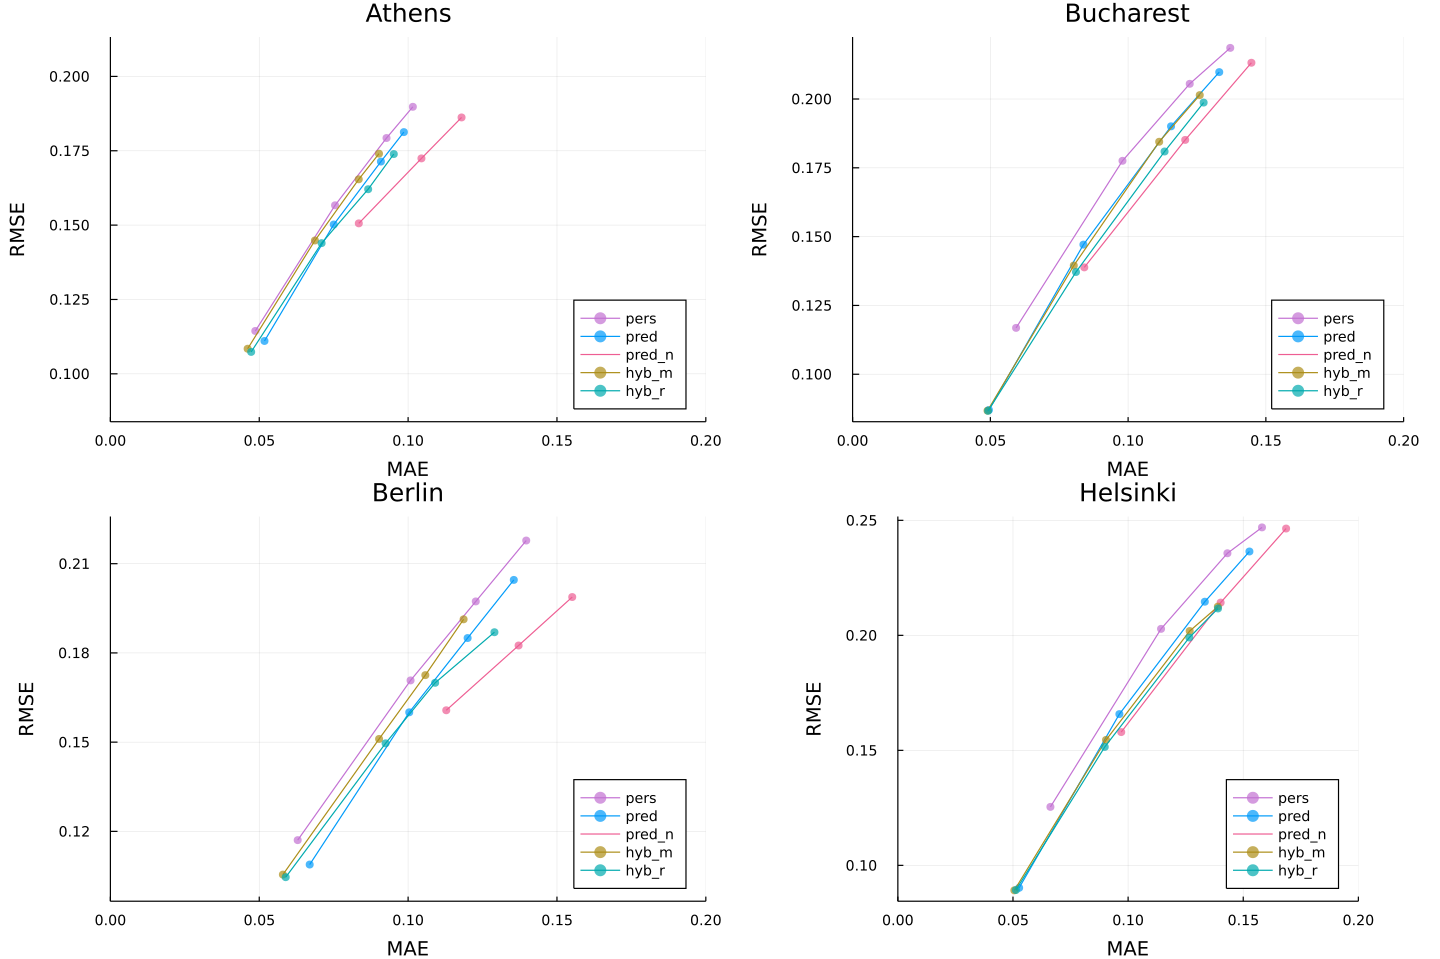

In [131]:
Fig. 6